In [1]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from tensorboardX import SummaryWriter

# 定义自己想用的网络
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        # 2维卷积 参数： 输入通道数， 输出通道数， 卷积核大小， 步长， 边界填0数
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        # relu 激活函数
        self.relu1 = nn.ReLU(inplace=True)
        # 最大池化 参数：池化核大小， 步长
        self.max_pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.max_pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten1 = nn.Flatten(start_dim=1, end_dim=-1)
        # 全连接层 参数： 输入特征长度， 输出特征长度
        self.linear1 = torch.nn.Linear(in_features=16*7*7, out_features=120)
        self.relu3 = nn.ReLU(inplace=True)
        self.linear2 = torch.nn.Linear(in_features=120, out_features=84)
        self.relu4 = nn.ReLU(inplace=True)
        self.linear3 = torch.nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.max_pool1(x)
        x = self.relu2(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        # 将数据的shape从 B C H W -> B C HW  
        x = self.flatten1(x)
        x = self.linear1(x)
        x = self.relu3(x)
        x = self.linear2(x)
        x = self.relu4(x)
        y = self.linear3(x)
        return y

# 设置超参数
num_epochs = 2
learning_rate = 0.001

# 学习率衰减系数
weight_decay = 5e-4
# 训练集的batchsize
batch_size_train = 64
# 测试集的batchsize
batch_size_test = 64

# 构造训练数据集trian_loader(dataset->dataloader)
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True)
# 构造测试数据集test_loader(dataset->dataloader)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True)

model = AlexNet()
print(model)

c:\Users\Administrator\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Administrator\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Administrator\AppData\Local\Programs\Python\Python38\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


AlexNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU(inplace=True)
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU(inplace=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=120, bias=True)
  (relu3): ReLU(inplace=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU(inplace=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)


In [2]:
criterion = nn.CrossEntropyLoss()
losses = [] #用于保存训练过程中的 loss 值
acces = []

def train(model, total_epochs, train_dataloader, test_dataloader, optim, save_dir, writer):
    model.train()
    best_acc = 0.0
    step_train = 0
    firststep = 0
    for epoch in range(num_epochs):
        dataloader = tqdm(train_dataloader)
        dataloader.set_description('epoch: {}/{}'.format(epoch + 1, num_epochs))
        for i, data in enumerate(dataloader):
            # 前向传播
            x_data = data[0]
            y_data = data[1]
            outs = model(x_data)
            acc = 0
            loss = F.cross_entropy(outs, y_data)
            # 计算每个batch的loss平均值
            avg_loss = torch.mean(loss)
            
            # 获取预测的标签
            preds = torch.argmax(outs, dim = 1)
            # 计算每个batchsize的acc
            acc = torch.sum(preds == y_data)/preds.shape[0]

            # 打印训练过程
            if i % 100 ==0:
                step_train += 1
                # scalar组件
                writer.add_scalar(tag="train/loss", scalar_value=avg_loss, global_step=step_train)
                writer.add_scalar(tag="train/acc", scalar_value=acc, global_step=step_train)

                losses.append(avg_loss.detach().numpy())
                acces.append(acc.detach().numpy())
                # print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch_id, batch_id, loss.detach().numpy(), acc.detach().numpy()))

            # 反向传播和优化
            avg_loss.backward()
            optim.step()

            writer.add_scalar(tag="train/loss", scalar_value=avg_loss, global_step=step_train)
            
            # losses.append(model .detach().numpy())
            if firststep==0:
                firststep=1
                tip = 0
                for parms in model.parameters():
                    tip += 1
                    if tip ==1:
                        filter1 = parms.grad
                    if tip ==3: #只有conv层可以可视化，maxpooling层和relu层不能可视化
                        filter3 = parms.grad
                

                torch.save({"conv1":filter1, "conv2":filter3},"./grad")

            optim.zero_grad()

            dataloader.set_postfix(loss='{:.4f}'.format(loss.detach().numpy()), acc='{:.4f}'.format(acc.detach().numpy()))
                
        # 保存每轮epoch的模型
        save_model_dir = save_dir +"/model{}".format(epoch+1)+".pth"
        # 保存的模型
        torch.save(model.state_dict(),save_model_dir )
        print("model is saved in: "+str(save_model_dir))

        # eval方法
        val_acc = eval(model, test_dataloader, epoch, writer)
        if val_acc > best_acc:
            # 保存最佳模型
            save_model_dir = save_dir +"/best_model"+".pth"
            # 保存模型
            torch.save(model.state_dict(), save_model_dir )
            print("best_model is saved in: "+str(save_model_dir))
            best_acc = val_acc
            print("best_acc: "+str(best_acc.detach().numpy()))

            

In [3]:
def eval(model, test_dataloader, epoch_id, writer):
    val_sums = []
    # 将模型设置为验证模式，这样就不会计算梯度
    model.eval()
    dataloader = tqdm(test_dataloader)
    dataloader.set_description('val')
    # 获取dataloader的数据
    for batch_id, data in enumerate(dataloader):
        # 获取第一个数据，即图像的tensor
        x_data = data[0]
        # 获取第二个数据，即图像的类别tensor
        y_data = data[1]
        # 将图像放入模型前向计算，并获取预测结果
        outs = model(x_data)
        
        # 获取预测结果的分类类别
        preds = torch.argmax(outs, dim = 1)
        # 计算预测准确的数量
        sums = torch.sum(preds == y_data)
        # 把每个batch的预测准确数量加入到数组中，便于后续计算acc
        val_sums.append(sums)
        
    # 添加验证集的图像
    # 将标签转为numpy类型
    tag = preds[epoch_id].detach().numpy()
    # print('tag:', tag)
    # 获取第epoch_id的图像tensor
    img = x_data[epoch_id,:,:,:]
    # 将tensor从 C H W -> H W C
    img = img.permute(1,2,0)
    writer.add_image(tag="数字: "+str(tag), global_step=epoch_id, img_tensor=img[:,:,0], dataformats='HW')

    # 添加验证集的acc变化
    # 计算acc，数组里预测准确数量总和除以数据总量
    val_acc = sum(val_sums)/len(test_dataloader.dataset)
    # 将特定图像加入到tensorboard
    writer.add_scalar(tag="val/acc", global_step=epoch_id, scalar_value=val_acc)
    print("batch_id: {}, acc is: {:.4f}".format(batch_id,  val_acc.detach().numpy()))
    return val_acc

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
save_dir = './ckp/MNIST/Adam1'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists('./log/MNIST/'):
    os.makedirs('./log/MNIST/')
writer = SummaryWriter(logdir= 'log/MNIST/Adam')

In [12]:
train(model, num_epochs, train_loader, test_loader, optimizer, save_dir, writer)
# 这部分可以多次运行，提高acc

epoch: 1/2: 100%|██████████| 938/938 [00:19<00:00, 48.31it/s, acc=1.0000, loss=0.0023]


model is saved in: ./ckp/MNIST/Adam1/model1.pth


val: 100%|██████████| 157/157 [00:02<00:00, 75.11it/s]


batch_id: 156, acc is: 0.9870
best_model is saved in: ./ckp/MNIST/Adam1/best_model.pth
best_acc: 0.987


epoch: 2/2: 100%|██████████| 938/938 [00:19<00:00, 48.40it/s, acc=1.0000, loss=0.0217]


model is saved in: ./ckp/MNIST/Adam1/model2.pth


val: 100%|██████████| 157/157 [00:02<00:00, 74.40it/s]

batch_id: 156, acc is: 0.9874
best_model is saved in: ./ckp/MNIST/Adam1/best_model.pth
best_acc: 0.9874


In [5]:
# 加载模型
model_dict = torch.load('./ckp/MNIST/Adam1/best_model.pth')
model.load_state_dict(model_dict)
# 模型设置为测试模式
model.eval() 
test_sums = []

for batch_id, data in enumerate(test_loader):
    # 获取数据
    # print(data[0].shape)
    x_data = data[0]
    y_data = data[1]
    # 模型的前向计算
    outs = model(x_data)
    # print(outs.shape)
    # 获取预测结果
    preds = torch.argmax(outs, dim = 1)
    sums = torch.sum(preds == y_data)
    test_sums.append(sums)
        
# 添加验证集的图像
# 和前面eval一样
tag = preds[0].detach().numpy()
print('tag:', tag)


tag: 1


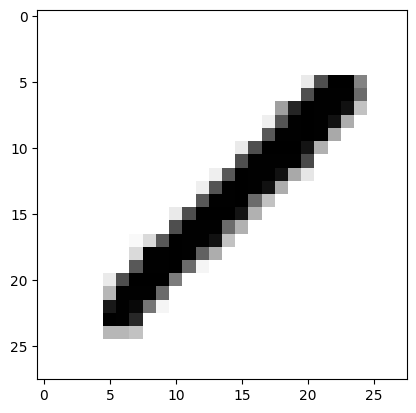

torch.Size([28, 28, 1])


In [6]:
# 由于图像是B C H W，只要batch的第一个
img = x_data[0,:,:,:]
# 将C H W-> H  W  C
img = img.permute(1,2,0)
# 图像显示
plt.figure()
plt.imshow(img[:,:,0], cmap=plt.cm.binary)  #图片大小为 [32,32]
plt.show()
print(img.shape)

可视化特征图

In [11]:
import os
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import argparse
import skimage.data
import skimage.io
import skimage.transform
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from PIL import Image
import cv2
 
#提取某一层网络特征图
class FeatureExtractor(nn.Module):
    def __init__(self, submodule, extracted_layers):
        super(FeatureExtractor, self).__init__()
        self.submodule = submodule
        self.extracted_layers = extracted_layers
 
    def forward(self, x):
        outputs = {}
        for name, module in self.submodule._modules.items():
            if "fc" in name:
                x = x.view(x.size(0), -1)
            x = module(x)
            if (self.extracted_layers is None) or (name in self.extracted_layers and 'fc' not in name):
                outputs[name] = x
        return outputs

def make_dirs(path):
    if os.path.exists(path) is False:
        os.makedirs(path)


# 由于图像是B C H W，只要batch的第一个
img = x_data[0,:,:,:]
# 插入维度
img = img.unsqueeze(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img = img.to(device)
net = model.to(device)
 
dst = './feautures'
therd_size = 256 # 放大的大小
 
myexactor = FeatureExtractor(submodule=net, extracted_layers=None)
output = myexactor(img)
#output是dict
#dict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc'])
# print(output)

for idx,val in enumerate(output.items()):
    k,v = val
    features = v[0]
    iter_range = features.shape[0]
    for i in range(iter_range):
        # plt.imshow(features.data.cpu().numpy()[i,:,:],cmap='jet')
        if 'fc' in k:  #不可视化fc层
            continue
 
        feature = features.data.cpu().numpy()
        # print(feature.shape)
        feature_img = feature[i]
        feature_img = np.asarray(feature_img * 255, dtype=np.uint8)
 
        dst_path = os.path.join(dst, str(idx)+'-'+k)
 
        make_dirs(dst_path)
        feature_img = cv2.applyColorMap(feature_img, cv2.COLORMAP_JET)
        if feature_img.shape[0] < therd_size:
            tmp_file = os.path.join(dst_path, str(i) + '_' + str(therd_size) + '.png')
            tmp_img = feature_img.copy()
            tmp_img = cv2.resize(tmp_img, (therd_size, therd_size), interpolation=cv2.INTER_NEAREST)
            cv2.imwrite(tmp_file, tmp_img)
 
        dst_file = os.path.join(dst_path, str(i) + '.png')
        cv2.imwrite(dst_file, feature_img)

total of number of filter :  6


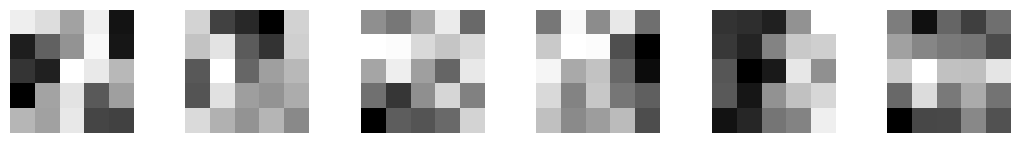

total of number of filter :  16


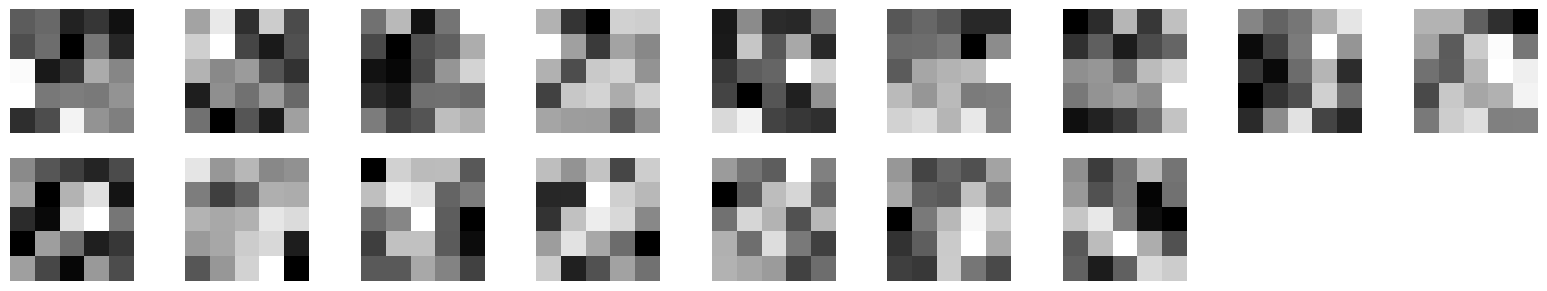

In [8]:
#卷积可视化
#将数据灌入模型后，pytorch框架会进行对应的前向传播，要对卷积核可视化，我们需要把卷积核从框架中提取出来。多谢torch提供的接口，我们可以直接把对应层的权重取出
for layer in dict(model.named_children()).keys():
    # print(layer)
    if layer not in ['conv1','conv2']: #只有conv层可以可视化，maxpooling层和relu层不能可视化
        continue
    filter = dict(model.named_children())[layer]
    filter = filter.weight.cpu().clone()
    print("total of number of filter : ", len(filter))
    num = len(filter)
    plt.figure(figsize=(20, 17))
    for i in range(0,num):
        plt.subplot(9, 9, i+1)
        plt.axis('off')
        plt.imshow(filter[i][0].detach(),cmap='gray')
    plt.show()

torch.Size([6, 1, 5, 5])


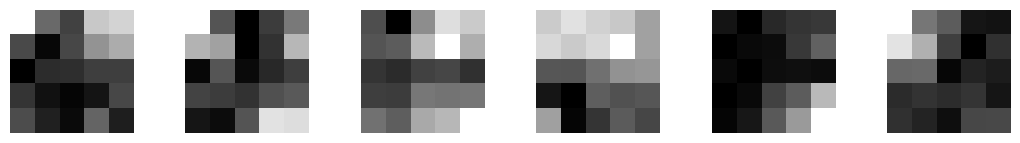

torch.Size([16, 6, 5, 5])


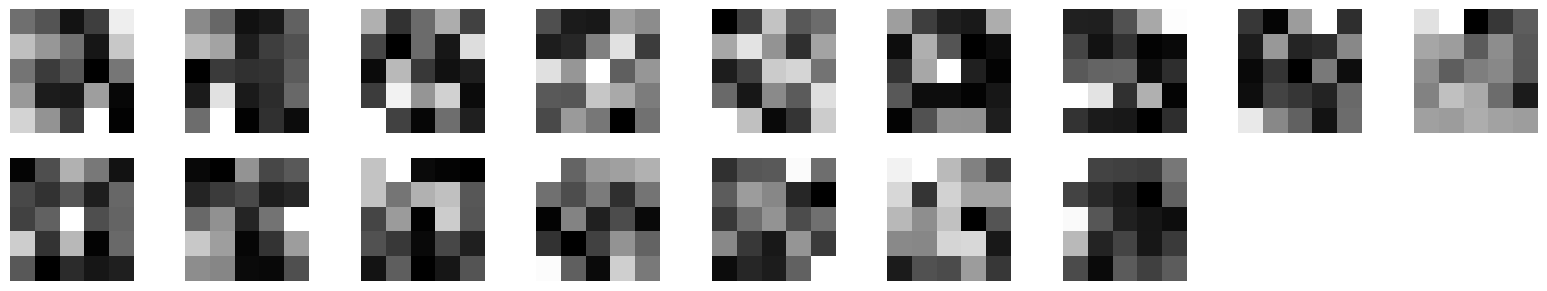

In [9]:
#可视化梯度信息
gradimg = torch.load("grad")
# print(gradimg)
for layer in gradimg.keys():
    filter = gradimg[layer]
    num = len(filter)
    print(filter.shape)
    plt.figure(figsize=(20, 17))
    for i in range(0,num):
        plt.subplot(9, 9, i+1)
        plt.axis('off')
        grad_img = np.abs(filter[i][0].detach().numpy())

        grad_img = (grad_img - np.min(grad_img)) / (np.max(grad_img) - np.min(grad_img))+0.5

        plt.imshow(grad_img,cmap='gray')
    plt.show()

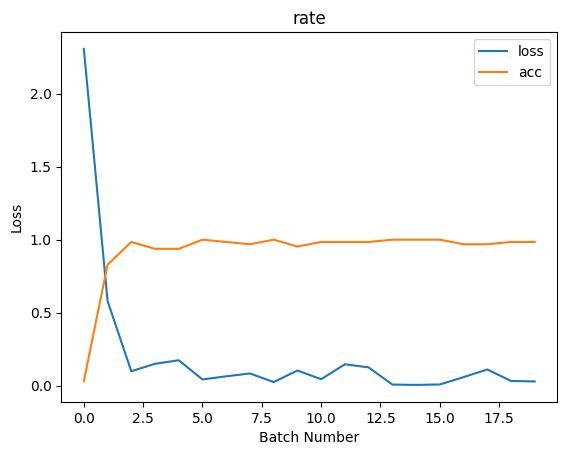

Accuracy of the model on the 10000 test images: 98.26 %


In [10]:
# 绘制损失图
plt.plot(losses)
plt.plot(acces)
plt.legend(["loss", "acc"])
plt.title('rate')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.show()
# 测试模型
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy of the model on the 10000 test images: {100 * correct / total} %')

# 保存模型
torch.save(model.state_dict(), 'model.pth')